In [66]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader


import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.style.use('seaborn-colorblind')

class CrossingDetector(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_dims = [8,100,100,1]
        self.layers = []
        for i, (in_dim, out_dim) in enumerate(zip(self.layer_dims[:-1], self.layer_dims[1:])):
            self.layers.append(nn.Linear(in_dim, out_dim))
            if i < len(self.layer_dims)-2:
                self.layers.append(nn.LeakyReLU())
            else:
                self.layers.append(nn.Sigmoid())
        self.main = nn.Sequential(*self.layers)
        
    def forward(self, x):
        return self.main(x)

In [67]:
def is_edges_crossed(x):
    return [is_edges_crossed_1(xi) for xi in x]

def is_edges_crossed_1(pos):
    return False
    
    
class EdgePairDataset():
    def __init__(self, n=1000):
        super().__init__()
        self.n = n
        self.data = torch.rand(n, 8)
        self.label = is_crossed(self.data)
        
    def __len__(self):
        return self.n
    
    def __getitem__(self, i):
        return self.data[i], self.label[i]
    

In [68]:
def draw_edge_pair(x):
    plt.plot([x[0], x[2]], [x[1], x[3]])
    plt.plot([x[4], x[6]], [x[5], x[7]])
    

In [69]:
dataset = EdgePairDataset()
dataloader = DataLoader(dataset, batch_size=16)
model = CrossingDetector()

tensor([[0.1505, 0.9780, 0.3297, 0.0027, 0.6196, 0.9974, 0.2842, 0.7252],
        [0.4473, 0.5697, 0.3057, 0.0495, 0.2475, 0.7375, 0.9513, 0.4313],
        [0.7599, 0.7381, 0.3652, 0.4565, 0.1316, 0.3227, 0.1266, 0.3148],
        [0.4265, 0.2784, 0.3854, 0.0608, 0.7548, 0.7240, 0.9942, 0.3432],
        [0.4675, 0.6620, 0.5669, 0.2075, 0.0707, 0.5025, 0.8180, 0.7584],
        [0.2408, 0.2940, 0.3593, 0.9196, 0.3459, 0.3305, 0.6186, 0.3248],
        [0.8175, 0.6328, 0.3116, 0.8128, 0.9212, 0.4269, 0.2817, 0.6380],
        [0.4423, 0.4714, 0.9219, 0.0966, 0.0810, 0.8423, 0.8502, 0.3822],
        [0.8781, 0.4362, 0.6911, 0.5949, 0.3474, 0.3359, 0.4803, 0.1665],
        [0.1516, 0.1782, 0.9164, 0.2609, 0.7906, 0.4635, 0.5157, 0.2535],
        [0.6330, 0.6090, 0.4168, 0.5290, 0.1553, 0.9511, 0.7599, 0.4126],
        [0.9033, 0.8256, 0.1631, 0.5972, 0.1392, 0.7808, 0.4325, 0.3228],
        [0.0989, 0.5584, 0.2174, 0.1146, 0.7580, 0.5176, 0.3417, 0.4024],
        [0.0560, 0.6312, 0.8164, 0.665

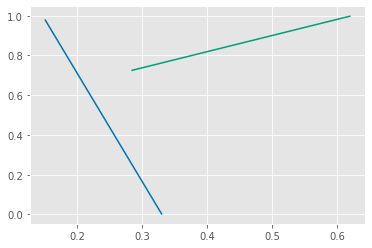

In [70]:
for edge_pairs, targets in dataloader:
    print(edge_pairs)
    print(targets)
    draw_edge_pair(edge_pairs[0])
    break